**Importar bibliotecas**

In [1]:
import pandas as pd
import shap
import pickle
import numpy as np 
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.over_sampling import KMeansSMOTE
from sklearn.utils import class_weight
from imblearn.over_sampling import ADASYN
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.utils.parallel import delayed
import warnings
warnings.filterwarnings("ignore")

**Importar dados brutos do QGIS**

## Explicar os dados brutos

In [90]:
sitios_dados = pd.read_csv(r'...\novo_modelo_calc.csv')

In [7]:
sitios_dados = sitios_dados.dropna()

**Dividir os conjuntos e normalizar os dados**

In [91]:
X  = sitios_dados.drop(['WKT', 'presenca','fid','_sunset_sv'], axis=1)
y = sitios_dados['presenca']
X = X.apply(lambda x:(x - x.min(axis= 0)) / (x.max(axis=0) - x.min(axis = 0)))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=30,
                                                    stratify=y)

print(f"Número de instâncias de treino por classe: {np.bincount(y_train)}")
print(f"Número de instâncias de teste por classe: {np.bincount(y_test)}")

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                    train_size=0.5, 
                                                    random_state=30,
                                                    stratify=y_test)
    
print(f"Número de instâncias de teste por classe: {np.bincount(y_test)}")
print(f"Número de instâncias de validação por classe: {np.bincount(y_val)}")

Numbers of train instances by class: [883 110]
Numbers of test instances by class: [380  47]
Numbers of test instances by class: [190  23]
Numbers of validation instances by class: [190  24]


**Exportar áreas positivas**

In [273]:
wkt = sitios_dados[['WKT', 'fid']]

y_val1 = pd.concat([wkt, y_val], axis = 1)

y_val1 = y_val1.query('presenca=="1"')

y_train1 = pd.concat([wkt, y_train], axis = 1)

y_train1 = y_train1.query('presenca=="1"')

y_test1 = pd.concat([wkt, y_test], axis = 1)

y_test1 = y_test1.query('presenca=="1"')

In [274]:
y_val1.to_csv(".../y_val1.csv", index = False)

y_train1.to_csv(".../y_train1.csv", index = False)

y_test1.to_csv(".../y_test1.csv", index = False)

**Salvar Conjuntos**

In [275]:
X_test.to_csv(".../X_test.csv", index = False)

X_val.to_csv(".../X_val.csv", index = False)

X_train.to_csv(".../X_train.csv", index = False)

y_val.to_csv(".../y_val.csv", index = False)

y_train.to_csv(".../y_train.csv", index = False)

y_test.to_csv(".../y_test.csv", index = False)

**Upload de dados de Treino/Teste/Validação**

In [2]:
X_val = pd.read_csv(r".../X_val.csv")

X_train = pd.read_csv(r".../X_train.csv")

y_val = pd.read_csv(r".../y_val.csv")

y_train = pd.read_csv(r".../y_train.csv")

X_test = pd.read_csv(r".../X_test.csv")

y_test = pd.read_csv(r".../y_test.csv")

**Reamostragem**

In [3]:
smote = SMOTE(random_state = 30)
X_smote_res, y_smote_res = smote.fit_resample(X_train,y_train)

In [10]:
kmsmote = KMeansSMOTE(random_state = 30, kmeans_estimator = 3, cluster_balance_threshold = 0.05)
X_smote_res, y_smote_res = kmsmote.fit_resample(X_train,y_train)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4


In [27]:
adasyn = ADASYN(random_state = 30)
X_smote_res, y_smote_res = adasyn.fit_resample(X_train,y_train)

**Função de Impressão de resultados**

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score

def print_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        pred = clf.predict(X_train)
        print("Resultado do Treino:\n===========================================")
        print ("acurácia",accuracy_score(y_train, pred))
        print ("valor de f1",f1_score(y_train, pred))     
        print ("precisão",precision_score(y_train, pred)) 
        print ("recall",recall_score(y_train, pred))
        print ("valor de f2", fbeta_score(y_train, pred, beta = 2))
        print(f"Matriz de confusão: \n {confusion_matrix(y_train, clf.predict(X_train))}\n")
    elif train==False:
        pred = clf.predict(X_val)
        print("Resultado do Teste:\n===========================================")        
        print ("acurácia",accuracy_score(y_val, pred))
        print ("valor de f1",f1_score(y_val, pred))     
        print ("precisão",precision_score(y_val, pred)) 
        print ("recall",recall_score(y_val, pred))
        print ("valor de f2", fbeta_score(y_val, pred, beta = 2))
        print(f"Matriz de Confusão: \n {confusion_matrix(y_val, pred)}\n")

**Execução dos Algoritmos**

Regressão Logística

In [29]:
lrmodel = LogisticRegression(penalty = "l2", max_iter = 500,  solver = "sag", random_state = 30) 
lrmodel.fit(X_smote_res, y_smote_res)

print_score(lrmodel, X_smote_res, y_smote_res, X_val, y_val, train=True)
print_score(lrmodel, X_smote_res, y_smote_res, X_val, y_val, train=False)

Train Result:
accuracy 0.8480725623582767
f1 score macro 0.8445475638051044
precision score 0.863582443653618
recall score 0.8263337116912599
f2 score 0.8335241584611862
Confusion Matrix: 
 [[768 115]
 [153 728]]

Test Result:
accuracy 0.8644859813084113
f1 score macro 0.6027397260273972
precision score 0.4489795918367347
recall score 0.9166666666666666
f2 score 0.7586206896551723
Confusion Matrix: 
 [[163  27]
 [  2  22]]



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


**Salvar os modelos executados** - A biblioteca "pickle" tem a função de exportar e importar os modelos executados. Após a execução dos modelos sempre haverá uma importação.

Reg. Log. Smote

In [152]:
with open('lrmodel_smote_walk.pkl', 'wb') as file:
    pickle.dump(lrmodel, file)

In [5]:
with open('lrmodel_smote_walk.pkl', 'rb') as f:
    lrmodel = pickle.load(f)

Reg. Log. Kmeans + Smote

In [20]:
with open('lrmodel_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(lrmodel, file)

In [35]:
with open('lrmodel_ksmote_walk.pkl', 'rb') as f:
    lrmodel = pickle.load(f)

Rede Neuronal Artificial (MLP)

In [30]:
mlp = MLPClassifier(max_iter = 2000, random_state = 30)
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','identity', 'logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive','invscaling'],
}


mlp_gs = GridSearchCV(mlp, params, n_jobs=-1, cv=3)
mlp_gs.fit(X_smote_res, y_smote_res)
best_mlp = mlp_gs.best_params_
print(f"Best paramters: {best_mlp})")

print_score(mlp_gs, X_smote_res, y_smote_res, X_val, y_val, train=True)
print_score(mlp_gs, X_smote_res, y_smote_res, X_val, y_val, train=False)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best paramters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'})
Train Result:
accuracy 1.0
f1 score macro 1.0
precision score 1.0
recall score 1.0
f2 score 1.0
Confusion Matrix: 
 [[883   0]
 [  0 881]]

Test Result:
accuracy 0.9439252336448598
f1 score macro 0.76
precision score 0.7307692307692307
recall score 0.7916666666666666
f2 score 0.7786885245901639
Confusion Matrix: 
 [[183   7]
 [  5  19]]



In [19]:
mlp = MLPClassifier(max_iter = 2000,activation ='relu', alpha = 0.05, hidden_layer_sizes= (100,), learning_rate = 'constant', solver = 'lbfgs', random_state = 30) 
mlp.fit(X_smote_res, y_smote_res)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(alpha=0.05, max_iter=2000, random_state=30, solver='lbfgs')

MLP Smote

In [21]:
with open('mlp_gs_smote_walk.pkl', 'wb') as file:
    pickle.dump(mlp_gs, file)
with open('mlp_smote_walk.pkl', 'wb') as file:
    pickle.dump(best_mlp, file)

In [6]:
with open('mlp_smote_walk.pkl', 'rb') as f:
   best_mlp = pickle.load(f)
with open('mlp_gs_smote_walk.pkl', 'rb') as f:
   mlp_gs = pickle.load(f)

MLP Kmeans + Smote

In [22]:
with open('mlp_gs_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(mlp_gs, file)

with open('mlp_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(best_mlp, file)

In [38]:
with open('mlp_gs_ksmote_walk.pkl', 'rb') as f:
   mlp_gs = pickle.load(f)
with open('mlp_ksmote_walk.pkl', 'rb') as f:
   best_mlp = pickle.load(f)

MLP Adasyn

In [37]:
with open('mlp_gs_adasyn_walk.pkl', 'wb') as file:
    pickle.dump(mlp_gs, file)
with open('mlp_adasyn_walk.pkl', 'wb') as file:
    pickle.dump(best_mlp, file)

In [6]:
with open('mlp_gs_adasyn_walk.pkl', 'rb') as f:
   mlp_gs = pickle.load(f)
with open('mlp_adasyn_walk.pkl', 'rb') as f:
   best_mlp = pickle.load(f)

Árvore de Decisão

In [31]:
tree_clf = DecisionTreeClassifier(random_state = 30)
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 15))), 
    "min_samples_split":[2,3,4], 
    "min_samples_leaf":list(range(1, 15)), 
}

tree_gs= GridSearchCV(tree_clf,params,cv = 5, n_jobs=-1)
tree_gs.fit(X_smote_res, y_smote_res)
best_tree = tree_gs.best_params_
print(f"Best paramters: {best_tree})")

print_score(tree_gs, X_smote_res, y_smote_res, X_val, y_val, train=True)
print_score(tree_gs, X_smote_res, y_smote_res, X_val, y_val, train=False)

Best paramters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
accuracy 0.9943310657596371
f1 score macro 0.9943181818181818
precision score 0.9954493742889647
recall score 0.9931895573212258
f2 score 0.9936406995230525
Confusion Matrix: 
 [[879   4]
 [  6 875]]

Test Result:
accuracy 0.897196261682243
f1 score macro 0.6333333333333333
precision score 0.5277777777777778
recall score 0.7916666666666666
f2 score 0.7196969696969697
Confusion Matrix: 
 [[173  17]
 [  5  19]]



DT Smote

In [155]:
with open('tree_gs_smote_walk.pkl', 'wb') as file:
    pickle.dump(tree_gs, file)

In [156]:
with open('tree_best_smote_walk.pkl', 'wb') as file:
    pickle.dump(best_tree, file)

In [7]:
with open('tree_gs_smote_walk.pkl', 'rb') as f:
    tree_gs = pickle.load(f)

In [8]:
with open('tree_best_smote_walk.pkl', 'rb') as f:
   best_tree = pickle.load(f)

Dt Kmeans + Smote

In [23]:
with open('tree_gs_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(tree_gs, file)
with open('tree_best_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(best_tree, file)

In [41]:
with open('tree_best_ksmote_walk.pkl', 'rb') as f:
   best_tree = pickle.load(f)
with open('tree_gs_ksmote_walk.pkl', 'rb') as f:
    tree_gs = pickle.load(f)

DT Adasyn

In [40]:
with open('tree_gs_adasyn_walk.pkl', 'wb') as file:
    pickle.dump(tree_gs, file)
with open('tree_best_adasyn_walk.pkl', 'wb') as file:
    pickle.dump(best_tree, file)

In [7]:
with open('tree_best_adasyn_walk.pkl', 'rb') as f:
   best_tree = pickle.load(f)
with open('tree_gs_adasyn_walk.pkl', 'rb') as f:
    tree_gs = pickle.load(f)

Floresta Aleatória

In [32]:
n_estimators = [100, 500, 1000, 1500]
max_features = ['sqrt']
max_depth = [2, 3, 5]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(n_estimators=100, random_state = 30)
rf_gs = GridSearchCV(rf_clf, random_grid, scoring="accuracy", cv=5, verbose=2, n_jobs=-1)


rf_gs.fit(X_smote_res, y_smote_res)

rf_best = rf_gs.best_estimator_

print(rf_gs.best_params_)
print_score(rf_gs, X_smote_res, y_smote_res, X_val, y_val, train=True)
print_score(rf_gs, X_smote_res, y_smote_res, X_val, y_val, train=False)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Train Result:
accuracy 1.0
f1 score macro 1.0
precision score 1.0
recall score 1.0
f2 score 1.0
Confusion Matrix: 
 [[883   0]
 [  0 881]]

Test Result:
accuracy 0.9626168224299065
f1 score macro 0.8333333333333334
precision score 0.8333333333333334
recall score 0.8333333333333334
f2 score 0.8333333333333334
Confusion Matrix: 
 [[186   4]
 [  4  20]]



RF Smote

In [36]:
with open('rf_best_smote_walk.pkl', 'wb') as file:
    pickle.dump(rf_best, file)
with open('rf_gs_smote_walk.pkl', 'wb') as file:
    pickle.dump(rf_gs, file)

In [9]:
with open('rf_best_smote_walk.pkl', 'rb') as f:
    rf_best = pickle.load(f)
with open('rf_gs_smote_walk.pkl', 'rb') as f:
    rf_gs = pickle.load(f)

RF Kmeans + Smote

In [24]:
with open('rf_best_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(rf_best, file)
with open('rf_gs_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(rf_gs, file)

In [45]:
with open('rf_gs_ksmote_walk.pkl', 'rb') as f:
    rf_gs = pickle.load(f)
with open('rf_best_ksmote_novo.pkl', 'rb') as f:
    rf_best = pickle.load(f)

RF Adasyn

In [43]:
with open('rf_best_adasyn_walk.pkl', 'wb') as file:
    pickle.dump(rf_best, file)
with open('rf_gs_adasyn_novo.pkl', 'wb') as file:
    pickle.dump(rf_gs, file)

In [8]:
with open('rf_best_adasyn_walk.pkl', 'rb') as f:
    rf_gs = pickle.load(f)
with open('rf_gs_adasyn_novo.pkl', 'rb') as f:
    rf_best = pickle.load(f)

Floresta Aleatória Balanceada

In [8]:
n_estimators = [100, 500, 1000, 1500]
max_features = ['sqrt', 'auto']
max_depth = [2, 3, 5]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}


brf_clf = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy = 'majority', class_weight = 'balanced', random_state = 30)
brf_gs = GridSearchCV(brf_clf, random_grid, scoring="accuracy", cv=5, verbose=2, n_jobs=-1)


brf_gs.fit(X_train, y_train)

brf_best = brf_gs.best_estimator_

print(brf_gs.best_params_)


print_score(brf_gs, X_train, y_train, X_val, y_val, train=True)
print_score(brf_gs, X_train, y_train, X_val, y_val, train=False)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Train Result:
accuracy 0.9577039274924471
f1 score macro 0.8396946564885496
precision score 0.7236842105263158
recall score 1.0
f2 score 0.9290540540540541
Confusion Matrix: 
 [[841  42]
 [  0 110]]

Test Result:
accuracy 0.9065420560747663
f1 score macro 0.6774193548387096
precision score 0.5526315789473685
recall score 0.875
f2 score 0.7835820895522388
Confusion Matrix: 
 [[173  17]
 [  3  21]]



In [28]:
print_score(brf_gs, X_train, y_train, X_val, y_val, train=True)
print_score(brf_gs, X_train, y_train, X_val, y_val, train=False)

Train Result:
accuracy 0.9577039274924471
f1 score macro 0.8396946564885496
precision score 0.7236842105263158
recall score 1.0
f2 score 0.9290540540540541
Confusion Matrix: 
 [[841  42]
 [  0 110]]



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Aspect Std. Dev.
- Curvature Profile std
- Diffuse Solar radiation summer solstice median
- Diffuse Solar radiation winter solstice median
- Dist Igneous Rock
- ...
Feature names seen at fit time, yet now missing:
- _aspectstd
- _demstdev
- _diffues_5
- _diffuese_
- _igneamedi
- ...


BRF Kmeans + Smote

In [16]:
with open('brf_best_smote_walk.pkl', 'wb') as file:
    pickle.dump(brf_best, file)

with open('brf_gs_smote_walk.pkl', 'wb') as file:
    pickle.dump(brf_gs, file)

In [10]:
with open('brf_gs_smote_walk.pkl', 'rb') as f:
    brf_gs = pickle.load(f)
with open('brf_best_smote_walk.pkl', 'rb') as f:
    brf_best = pickle.load(f)

BRF Adasyn

Bagging Balanceado

In [11]:
bagbal_clf = BalancedBaggingClassifier(random_state=30)
bagbal_clf.fit(X_train, y_train)

print_score(bagbal_clf, X_train, y_train, X_val, y_val, train=True)
print_score(bagbal_clf, X_train, y_train, X_val, y_val, train=False)

Resultado do Treino:
acurácia 0.9516616314199395
valor de f1 0.8167938931297711
precisão 0.7039473684210527
recall 0.9727272727272728
valor de f2 0.9037162162162163
Matriz de confusão: 
 [[838  45]
 [  3 107]]

Resultado do Teste:
acurácia 0.9252336448598131
valor de f1 0.7241379310344829
precisão 0.6176470588235294
recall 0.875
valor de f2 0.8076923076923076
Matriz de Confusão: 
 [[177  13]
 [  3  21]]



Ensemble soft

In [33]:

ensemble_s = VotingClassifier(estimators = [('rf_clf', rf_gs), ('lrmodel', lrmodel), ('brf_clf', brf_gs), ('bagbal_clf', bagbal_clf),('tree_clf', tree_gs),('mlp', mlp_gs)], voting='soft')

In [34]:
ensemble_s.fit(X_train, y_train)
print_score(ensemble_s, X_train, y_train, X_val, y_val, train=True)
print_score(ensemble_s, X_train, y_train, X_val, y_val, train=False)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

Train Result:
accuracy 0.998992950654582
f1 score macro 0.9954751131221719
precision score 0.990990990990991
recall score 1.0
f2 score 0.998185117967332
Confusion Matrix: 
 [[882   1]
 [  0 110]]

Test Result:
accuracy 0.9439252336448598
f1 score macro 0.7391304347826088
precision score 0.7727272727272727
recall score 0.7083333333333334
f2 score 0.7203389830508474
Confusion Matrix: 
 [[185   5]
 [  7  17]]



Ensemble Smote

In [333]:
with open('ensemble_s_smote_walk.pkl', 'wb') as file:
    pickle.dump(ensemble_s, file)

In [12]:
with open('ensemble_s_smote_walk.pkl', 'rb') as f:
    ensemble_s = pickle.load(f)

Ensemble Kmeans + Smote

In [25]:
with open('ensemble_s_ksmote_walk.pkl', 'wb') as file:
    pickle.dump(ensemble_s, file)

In [48]:
with open('ensemble_s_ksmote_walk.pkl', 'rb') as f:
    ensemble_s = pickle.load(f)

In [49]:
print_score(ensemble_s, X_train, y_train, X_val, y_val, train=True)
print_score(ensemble_s, X_train, y_train, X_val, y_val, train=False)

Train Result:
accuracy 0.998992950654582
f1 score macro 0.9954751131221719
precision score 0.990990990990991
recall score 1.0
f2 score 0.998185117967332
Confusion Matrix: 
 [[882   1]
 [  0 110]]

Test Result:
accuracy 0.9439252336448598
f1 score macro 0.7391304347826088
precision score 0.7727272727272727
recall score 0.7083333333333334
f2 score 0.7203389830508474
Confusion Matrix: 
 [[185   5]
 [  7  17]]



Ensemble  Adasyn

In [47]:
with open('ensemble_s_adasyn_walk.pkl', 'wb') as file:
    pickle.dump(ensemble_s, file)

In [45]:
with open('ensemble_s_adasyn_walk.pkl', 'rb') as f:
    ensemble_s = pickle.load(f)

**Importância das variáveis (SHAP value)** - Para criar os mais diversos modelos explicativos, o SHAP se vale das ideias base da Teoria dos Jogos. Primeiramente é preciso pois, transformar as variáveis em jogadores e as funções do modelo de AM nas regras do jogo. Assim como nos jogos, onde um jogador pode ou não se juntar a uma partida, os atributos de um modelo, podem ou não contribuir ou estar inserido em um determinado modelo. Dito isto, toda vez que tivermos os valores das variáveis, é sabido que as mesmas participaram do cálculo, do contrário, temos a certeza que elas não participaram e portanto não interferiram no modelo (LUNDBERG; LEE, 2017).

Regressão Logística

In [10]:
shap.initjs()

In [15]:
masker = shap.maskers.Impute(data=X_train)
explainer_rl = shap.LinearExplainer(lrmodel, masker = masker,approximate=True)
shap_values_rl = explainer_rl.shap_values(X_train)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

In [284]:
X_train.rename(columns={'_vistdev':'Visibility Index std','_sunset__5': 'Solar radiation sunset summer solstice median', '_sunset__6': 'Solar radiation summer solstice std', '_aspectstd':'Aspect Std. Dev.','_ordem_dre':'Dist. main water courses median','_sunrise_s':'Solar radiation sunrise winter solstice median',
       '_sunrise_1':'Solar radiation sunrise winter solstice std','_igneamedi':'Dist Igneous Rock','_demstdev':'Eelvation std','_slopemedi':'Slope median' }, inplace=True)

In [71]:
X_train.columns[0:50]

Index(['_aspectmed', 'Aspect Std. Dev.',
       'Diffuse Solar radiation summer solstice median', '_diffues_1',
       'Diffuse Solar radiation winter solstice median', '_diffues_6',
       '_direct_in', '_direct__1', '_direct__5', '_direct__6',
       'Dist Igneous Rock median', '_igneastde',
       'Dist metamorphic rock median', 'Dist metamorphic rock std',
       'Dist. main water courses median', '_ordem_d_1', '_perfil_cu',
       'Curvature Profile std', 'Elevation median', 'Eelvation std',
       'Dist. Sedimentary Rock', 'Dist. Sedimentary Rock', 'Slope median',
       '_slopestde', 'Solar radiation sunrise winter solstice median',
       'Solar radiation sunrise winter solstice std', '_sunrise_5',
       '_sunrise_6', '_sunset_si',
       'Solar radiation sunset winter solstice std',
       'Solar radiation sunset summer solstice median',
       'Solar radiation sunset summer solstice std', '_total_ins',
       '_total_i_1', '_total_i_5', '_total_i_6', 'TPI median', '_tpistdev

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


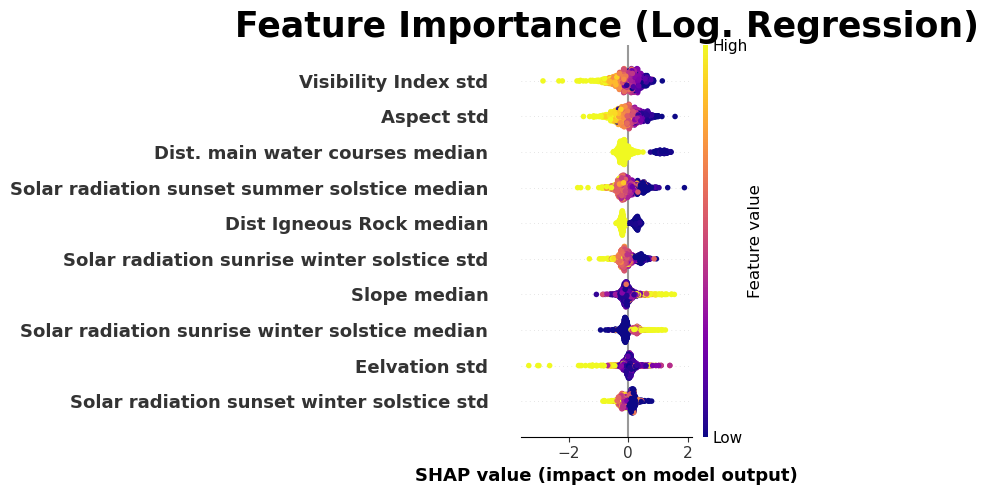

In [75]:
plt.title("Feature Importance (Log. Regression)", fontsize = 25, weight = "bold")
plt.yticks(fontsize = 12,weight = "semibold",ha='right')
plt.xlabel(r'Shap Values', fontsize = 20, weight = "semibold")



shap.summary_plot(shap_values_rl, 
                  X_train,
                  cmap = "plasma", max_display = 10)


Rede Neuronal Artificial (MLP)

In [20]:
explainer_mlp = shap.KernelExplainer(mlp.predict,X_train)
shap_values_mlp = explainer_mlp.shap_values(X_val, nsamples= 100)

X does not have valid feature names, but MLPClassifier was fitted with feature names
Using 993 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/214 [00:00<?, ?it/s]

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


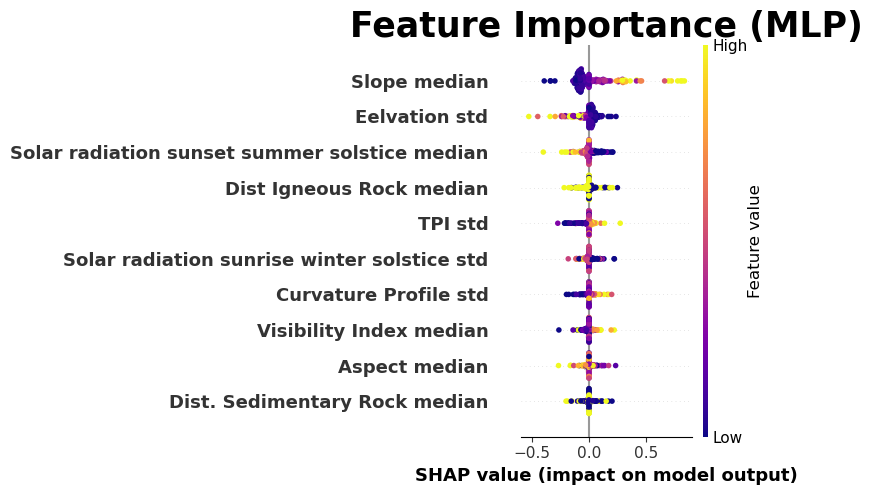

In [59]:
fig = plt.figure(figsize=(10,15))


plt.title("Feature Importance (MLP)", fontsize = 25, weight = "bold")
plt.yticks(fontsize = 12,weight = "semibold",ha='right')
plt.xlabel(r'Shap Values', fontsize = 20, weight = "semibold")

shap.summary_plot(shap_values_mlp, X_val.astype("float"), max_display = 10, plot_type="dot",cmap = 'plasma')

plt.show()

In [72]:
X_val.rename(columns={'_tpistdev':'TPI std','_vimedian':'Visibility Index median','_aspectmed':'Aspect median','_vistdev':'Visibility Index std','_sunset__5': 'Solar radiation sunset summer solstice median', '_sunset__6': 'Solar radiation sunset summer solstice std', 'Aspect Std. Dev.':'Aspect std','_ordem_dre':'Dist. main water courses median','_sunrise_s':'Solar radiation sunrise winter solstice median',
       '_sunrise_1':'Solar radiation sunrise winter solstice std','_igneamedi':'Dist Igneous Rock median','_demstdev':'Eelvation std','_slopemedi':'Slope median', '_perfil__1':'Curvature Profile std','_diffuese_':'Diffuse Solar radiation summer solstice median', '_sedmedian': 'Dist. Sedimentary Rock median','_diffues_5': 'Diffuse Solar radiation winter solstice median',
                     '_metamedia': 'Dist metamorphic rock median', '_metastdev':'Dist metamorphic rock std','_sedstdev':'Dist. Sedimentary Rock std','_demmedian':'Elevation median','_tpimedian':'TPI median'}, inplace=True)

Floresta Aleatória

In [38]:
explainer_rf = shap.TreeExplainer(rf_best)
shap_values_rf = explainer_rf.shap_values(X_train)

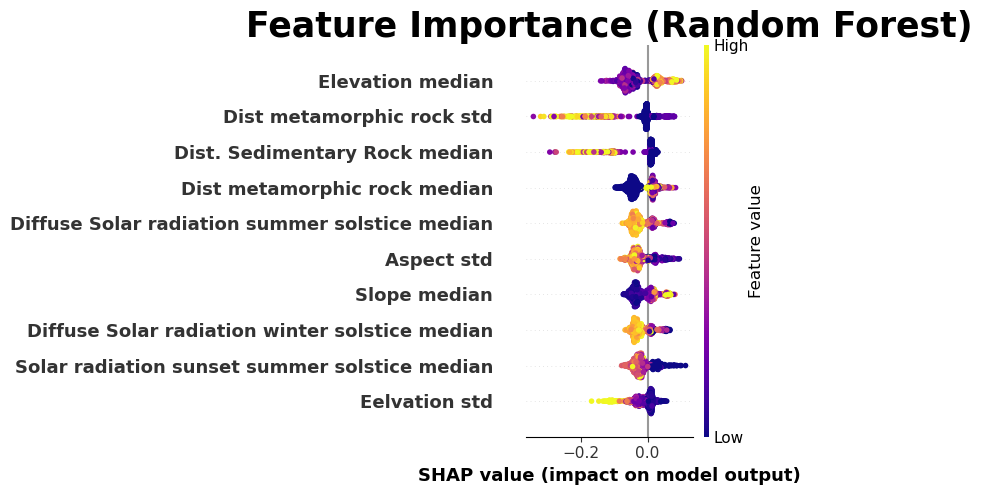

In [76]:
plt.title("Feature Importance (Random Forest)", fontsize = 25, weight = "bold")
plt.yticks(fontsize = 12,weight = "semibold",ha='right')
plt.xlabel(r'Shap Values', fontsize = 20, weight = "semibold")

shap.summary_plot(shap_values_rf[1], 
                  X_train,
                  cmap = "plasma", max_display = 10)


In [63]:
X_train.rename(columns={'_sunset__1':'Solar radiation sunset winter solstice std','_vistdev':'Visibility Index std','_sunset__5': 'Solar radiation sunset summer solstice median', '_sunset__6': 'Solar radiation sunset summer solstice std', '_aspectstd':'Aspect Std. Dev.','_ordem_dre':'Dist. main water courses median','_sunrise_s':'Solar radiation sunrise winter solstice median',
       '_sunrise_1':'Solar radiation sunrise winter solstice std','_igneamedi':'Dist Igneous Rock median','_demstdev':'Eelvation std','_slopemedi':'Slope median', '_perfil__1':'Curvature Profile std','_diffuese_':'Diffuse Solar radiation summer solstice median', '_sedmedian': 'Dist. Sedimentary Rock median','_diffues_5': 'Diffuse Solar radiation winter solstice median',
                     '_metamedia': 'Dist metamorphic rock median', '_metastdev':'Dist metamorphic rock std','_sedstdev':'Dist. Sedimentary Rock std','_demmedian':'Elevation median','_tpimedian':'TPI median'}, inplace=True)

In [74]:
X_train.rename(columns={'Aspect Std. Dev.':'Aspect std','Dist. Sedimentary Rock':'Dist. Sedimentary Rock std','Dist. Sedimentary Rock': 'Dist. Sedimentary Rock median'}, inplace=True)

Floresta Aleatória Balanceada

In [41]:
explainer_brf = shap.TreeExplainer(brf_best)
shap_values_brf = explainer_brf.shap_values(X_train)

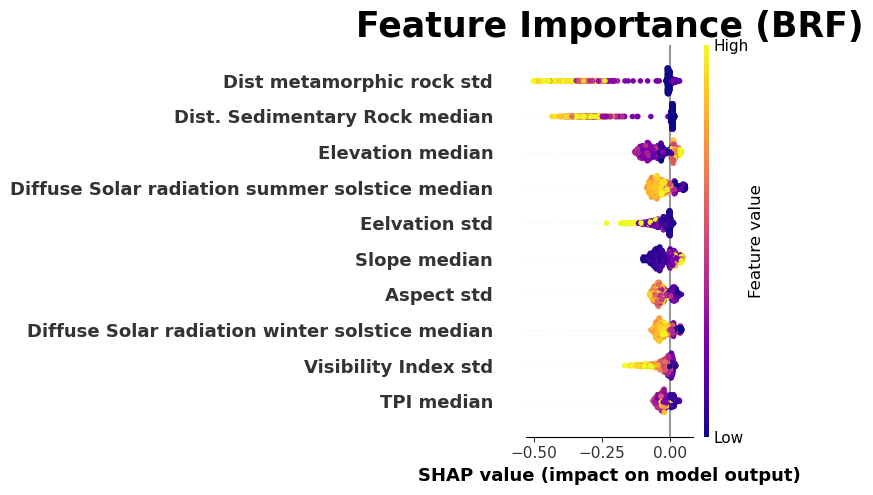

In [77]:
plt.title("Feature Importance (BRF)", fontsize = 25, weight = "bold")
plt.yticks(fontsize = 12,weight = "semibold",ha='right')
plt.xlabel(r'Shap Values', fontsize = 20, weight = "semibold")

shap.summary_plot(shap_values_brf[1], 
                  X_train,
                  cmap = "plasma", max_display = 10)

In [ ]:
X_train.rename(columns={'_prox_slopemedian':'Prox. CMC Declividade Mediana','_prox_slopemajority':'Prox. CMC Declividade Moda','_prox_slopemax': 'Prox. CMC Declividade Máx.','_perfil_curvmajority':'Perfil Curv. Moda','_sunrise_sistdev':'Ins.Nascer do Sol (SI) Desvio','_aspectmax':'Aspecto Máx.','_meta_proxstdev':'Prox. Rochas Metamórficas Desvio','_meta_proxvariance':'Prox. Rochas Metamórficas Var.','_demvariance': 'Elevação Var.','_sed_proxstdev':'Prox. Rochas Sedimentares Desvio','_sed_proxvariance':'Prox. Rochas Sedimentares Var.','_ordem_drenstdev':'Proximidade Principais Dren Desvio','_perfil_curvmedian':'Perfil Curv. Mediana','_aspectvariance':'Aspecto Var.','_demstdev':'Elevação Desvio','_meta_proxmedian':'Prox. Rochas Metamórficas','_vimax': 'IV Máx.', '_vistdev': 'IV Desvio','_sunset_sistdev':'Ins. Pôr do Sol (SI) Desvio ', '_sunset_svstdev':'Ins. Pôr do Sol (SV) Desvio', '_total_insol_svmax': 'Ins. Total (SV) Máx','_vivariance':'IV Var.','_direct_insol_svmax': 'Insol. Direta (SV) Máx','_perfil_curvmax':'Perfil Curvatura Máx', '_tpimax':'ITP Máx.','_perfil_curvstdev':'Perfil Curvatura Desvio'}, inplace=True)

**Modelo Final e Export**

Importar dados desconhecidos do QGIS

In [64]:
Y_ = pd.read_csv(r'....\pajeu_norte_walk_calc.csv')

In [65]:
Z_ = pd.read_csv(r'...\pajeu_sul_walk_calc.csv')

In [66]:
X_ = Y_.merge(Z_, how='outer')

retirar valores inúteis ao cálculo

In [67]:
X_ = X_.drop(['WKT', 'left', 'top', 'right', 'bottom', 'id','fid'], axis = 1)

In [165]:
X_ = X_.drop(['_aspectmax', '_aspectmajority', '_aspectvariance','_diffuse_insol_svmax', '_diffuse_insol_svmajority',
       '_diffuse_insol_svvariance','_diffuse_insol_simax','_diffuse_insol_simajority', '_diffuse_insol_sivariance', '_direct_insol_simax', '_direct_insol_simajority',
       '_direct_insol_sivariance','_direct_insol_svmax','_direct_insol_svmajority', '_direct_insol_svvariance','_igneamax', '_igneamajority', '_igneavariance','_metamax', '_metamajority',
       '_metavariance','_ordem_drenmax', '_ordem_drenmajority', '_ordem_drenvariance','_perfil_curvmax',
       '_perfil_curvmajority', '_perfil_curvvariance','_demmax',
       '_demmajority', '_demvariance',
                       '_sedmax',
       '_sedmajority', '_sedvariance','_slopemax', '_slopemajority', '_slopevariance',
                       '_sunrise_simax', '_sunrise_simajority',
       '_sunrise_sivariance','_sunrise_svmax', '_sunrise_svmajority', '_sunrise_svvariance',
                       '_sunset_simax',
       '_sunset_simajority', '_sunset_sivariance','_sunset_svmax', '_sunset_svmajority',
       '_sunset_svvariance', 
                       '_total_insol_simax', '_total_insol_simajority',
       '_total_insol_sivariance','_total_insol_svmax', '_total_insol_svmajority',
       '_total_insol_svvariance',
                       '_tpimax',
       '_tpimajority', '_tpivariance','_vimax', '_vimajority',
       '_vivariance',
                       '_dens_insolmedian', '_dens_insolstdev', '_dens_insolmax',
       '_dens_insolmajority', '_dens_insolvariance', '_dens_slopemedian',
       '_dens_slopestdev', '_dens_slopemax', '_dens_slopemajority',
       '_dens_slopevariance', '_prox_insolmedian', '_prox_insolstdev',
       '_prox_insolmax', '_prox_insolmajority', '_prox_insolvariance',
       '_prox_slopemedian', '_prox_slopestdev', '_prox_slopemax',
       '_prox_slopemajority', '_prox_slopevariance'], axis=1)

**##Atenção##** Se por algum motivo a suas colunas de variáveis tiverem nomes diferentes você precisará usar a linha de código abaixo para deixar tudo igual. É bom prestar atenção quando importar a tabela do qgis para o python, pois as vezes, a depender da versão, acaba mudando o nome da coluna. Um outro ponto importante é deixar as colunas dos dados desconhecidos na mesma ordem do dado treinado, para que não haja nenhum erro.

In [68]:
X_ = X_.rename(columns=dict(zip(X_.columns, X_train.columns)))

Retirar valores nulos e normalizar os dados

In [69]:
X_.dropna(inplace=True)

In [70]:
X_ = X_.apply(lambda x:(x - x.min(axis= 0)) / (x.max(axis=0) - x.min(axis = 0)))

**Calcular a pevisão** - O predict_proba() é utilizado para obter a probabilidade do local ser um sítio ou uma área de ausência de acordo com um range que vai de 0 a 1. Quanto mais próximo de "0" maior a chance do local ser uma área de ausência e quanto mais próximo de 1, maior a chance de ser um sítio. 

In [71]:
pred =ensemble_s.predict_proba(X_)

In [72]:
m2 = pred[:,1]
X_['presenca'] = pd.Series(pred.flatten())

In [73]:
pred_quad1pd = pd.DataFrame(m2, columns = ['presenca'])

In [23]:
Y_1 = pd.read_csv(r'...\pajeu_norte_walk_calc.csv')

In [24]:
Z_1 = pd.read_csv(r'...\pajeu_sul_walk_calc.csv')

In [25]:
X_1 = Y_1.merge(Z_1, how='outer')

In [74]:
quad1 = pd.concat([pred_quad1pd, X_1], axis = 1)

Exportar os dados como csv

In [75]:
quad1.to_csv(".../ensemble_smote_walk_merge.csv", index = False)